# Import Libraries


In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Load Dataset


In [16]:
df = pd.read_pickle("./processed_objects/app_review_labeled.pkl")

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13631 entries, 0 to 13630
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              13631 non-null  object
 1   userName              13631 non-null  object
 2   userImage             13631 non-null  object
 3   content               13631 non-null  object
 4   score                 13631 non-null  int64 
 5   thumbsUpCount         13631 non-null  int64 
 6   reviewCreatedVersion  13631 non-null  object
 7   at                    13631 non-null  object
 8   replyContent          13631 non-null  object
 9   repliedAt             13631 non-null  object
 10  appVersion            13631 non-null  object
 11  content_en            13631 non-null  object
 12  cleaned_content_en    13631 non-null  object
 13  Stanford Score        13631 non-null  object
 14  Stanford Label        13631 non-null  object
dtypes: int64(2), object(13)
memory usage

In [18]:
features_df = df.loc[:, ["cleaned_content_en", "Stanford Label"]]
features_df

,cleaned_content_en,Stanford Label
0,already difficult login account tried week man...,Negative
1,need day application opened used even though w...,Negative
2,application often opened logouts sometimes ret...,Negative
3,already paid even bolt continuously dkira pay ...,Negative
4,open bond investment portfolio always horror s...,Negative
...,...,...
13626,since last month never logged oppo f always fa...,Negative
13627,please help application,Positive
13628,try see first,Neutral
13629,good,Positive


In [19]:
features_df = features_df.astype({
    "cleaned_content_en": "string",
    "Stanford Label": "string"
})

In [20]:
features_df

,cleaned_content_en,Stanford Label
0,already difficult login account tried week man...,Negative
1,need day application opened used even though w...,Negative
2,application often opened logouts sometimes ret...,Negative
3,already paid even bolt continuously dkira pay ...,Negative
4,open bond investment portfolio always horror s...,Negative
...,...,...
13626,since last month never logged oppo f always fa...,Negative
13627,please help application,Positive
13628,try see first,Neutral
13629,good,Positive


In [21]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13631 entries, 0 to 13630
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   cleaned_content_en  13631 non-null  string
 1   Stanford Label      13631 non-null  string
dtypes: string(2)
memory usage: 213.1 KB


# Helper Functions


In [ ]:
stanford_Labels = {
    "Negative": "Neg",
    "Neutral": "Neu",
    "Positive": "Pos",
    "Verynegative": "VNeg",
    "Verypositive": "VPos",
}


def label_encoding(series):
    one_hot_encoder = OneHotEncoder(sparse_output=False)
    df = one_hot_encoder.fit_transform(series.to_frame())
    return df

In [24]:
df.loc[:, 'Content Length'] = df['cleaned_content_en'].astype(
    str).apply(lambda x: len(x.split(" ")))

<Axes: >

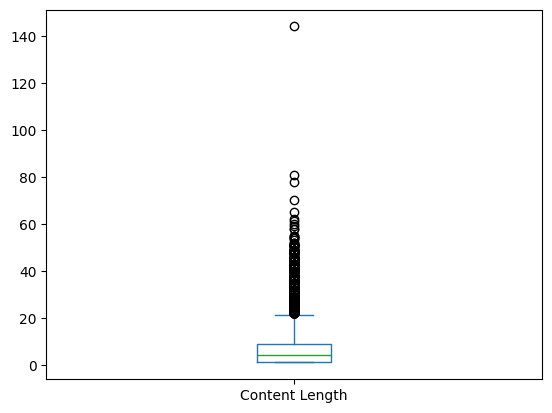

In [25]:
df['Content Length'].plot(kind='box')

# Split the Data


In [26]:
features_df.loc[:, "Stanford Label"] = features_df.loc[:,
                                                       "Stanford Label"].map(stanford_Labels)

In [27]:
features_df.head()

,cleaned_content_en,Stanford Label
0,already difficult login account tried week man...,Neg
1,need day application opened used even though w...,Neg
2,application often opened logouts sometimes ret...,Neg
3,already paid even bolt continuously dkira pay ...,Neg
4,open bond investment portfolio always horror s...,Neg


In [28]:
train_df, test_df = train_test_split(
    features_df,
    test_size=0.2,
    stratify=features_df["Stanford Label"],
    random_state=42
)

In [29]:
train_df, val_df = train_test_split(
    train_df,
    test_size=(2/9),
    stratify=train_df['Stanford Label'],
    random_state=42
)

# Label Encoding


In [30]:
X_train = train_df["cleaned_content_en"]
X_test = test_df["cleaned_content_en"]
X_val = val_df["cleaned_content_en"]

In [31]:
Y_train = label_encoding(
    train_df.loc[:, 'Stanford Label']
)

Y_val = label_encoding(
    val_df.loc[:, 'Stanford Label']
)

Y_test = label_encoding(
    test_df.loc[:, 'Stanford Label']
)

In [ ]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit_transform(train_df['Stanford Label'].to_frame())

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

# Data Preparation for Neural Network


In [17]:
sentences = [sentence.split() for sentence in X_train]

In [18]:
oov_token = "<OOV>"
padding_type = 'post'
trunc_type = 'post'

In [19]:
tokenizer = Tokenizer(oov_token=oov_token)
tokenizer.fit_on_texts(sentences)

train_sequences = tokenizer.texts_to_sequences(X_train.tolist())
val_sequences = tokenizer.texts_to_sequences(X_val.tolist())
test_sequences = tokenizer.texts_to_sequences(X_test.tolist())

train_data = pad_sequences(
    train_sequences, truncating=trunc_type, padding='post').astype(float, copy=False)
val_data = pad_sequences(val_sequences, truncating=trunc_type,
                         padding='post').astype(float, copy=False)
test_data = pad_sequences(
    test_sequences, truncating=trunc_type, padding='post').astype(float, copy=False)

# Save Prepared Data


In [21]:
with open('./processed_objects/features_data.npy', 'wb') as file:
    np.save(file, train_data)
    np.save(file, val_data)
    np.save(file, test_data)

with open('./processed_objects/target_data.npy', 'wb') as file:
    np.save(file, Y_train)
    np.save(file, Y_val)
    np.save(file, Y_test)

with open('./processed_objects/training_corpus.pkl', 'wb') as file:
    pickle.dump(sentences, file)

with open('./processed_objects/word_index.pkl', 'wb') as file:
    pickle.dump(tokenizer.word_index, file)